In [37]:
import matplotlib.pyplot as plt
import casadi as cs
import numpy as np
from typing import Union

## symbolic state and control vector using casadi' MX variable

In [38]:
Nx = 2
Nu = 1
x = cs.MX.sym("x", Nx, 1)
u = cs.MX.sym("u", Nu, 1)

## functions for Lagrange integrand, dynamics and other constants

In [39]:
L = u**2
L = cs.Function('L', [x, u], [L])

f = cs.vcat([x[1], -x[1]+u])
f = cs.Function('L', [x, u], [f])

x_t0 = cs.DM.zeros(2, 1)
a, b = (2.694528, 1.155356)

## discretized time grid

In [40]:
t0 = 0
tf = 2
N = 200
t = cs.linspace(t0, tf, N+1)
dt = (tf-t0)/N

## NLP using casadi's Opti() class

In [41]:
nlp = cs.Opti()
X = nlp.variable(Nx, N+1)
U = nlp.variable(Nu, N)

# different numerical methods for transcription

In [42]:
cs_type = Union[cs.MX, cs.SX, cs.DM]

def obj_int(dt: cs_type, xv: cs_type, uv: cs_type, L: cs.Function, op: str):

    if op == "rie": # Riemann sum
        return dt*cs.sum2(L(xv[:, 0:N], uv))
    elif op == "trap": # trapezoidal
        return 0.5*dt*cs.sum2(L(xv[:, 0:N], uv)+L(xv[:, 1:N+1], uv))
    else:
        raise ValueError("wrong option")

def dyn_int(dt: cs_type, xv: cs_type, uv: cs_type, f: cs.Function, op: str):

    if op == "ef": # forward Euler
        xl = xv[:, 0:N]
        xr = xv[:, 1:N+1]
        return cs.vec(xr-xl-dt*(f(xl, uv)))
    elif op == "trap": # trapezoidal
        xl = xv[:, 0:N]
        xr = xv[:, 1:N+1]
        return cs.vec(xr-xl-dt*(f(xl, uv)+f(xr, uv)))
    elif op == "her": # hermite simpson
        xl = xv[:, 0:N]
        xr = xv[:, 1:N+1]
        xc = 0.5*(xl+xr)+1/8*(f(xl, uv)-f(xr, uv))
        return cs.vec(xr-xl-dt/6*(f(xl, uv)+4*f(xc, uv)+f(xr, uv)))
    elif op == "rk4": # runge kutta 4
        xl = xv[:, 0:N]
        xr = xv[:, 1:N+1]
        k1 = f(xl, uv)
        k2 = f(xl+k1*dt/2, uv)
        k3 = f(xl+k2*dt/2, uv)
        k4 = f(xl+k3*dt, uv)
        return cs.vec(xr-xl-1/6*dt*(k1+2*k2+2*k3+k4))
    else:
        raise ValueError("wrong option")

## Choose numerical methods for transcription

### objective
* riemann sum (rie)
* trapezoidal (trap)

###
* euler forward (ef)
* trapezoidal (trap)
* hermite simpson (her)
* runge kutta 4 (rk4)

In [43]:
oop = 'trap'
dop = 'rk4'

## transcription of the optimal control problem

In [44]:
obj_L = obj_int(dt, X, U, L, oop)
obj_E = 0
res = dyn_int(dt, X, U, f, dop)

## solve NLP using IPOPT

In [45]:
nlp.minimize(obj_L+obj_E)
nlp.subject_to(X[:, 0]-x_t0 == 0)
nlp.subject_to(res == 0)
nlp.subject_to(X[0, N]-a*X[1, N]+b == 0)
nlp.solver('ipopt')
sol=nlp.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1404
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      602
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      403
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.16e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

## analytical solution

In [46]:
t=(t.full().flatten())
us=np.exp(t)/4-1/2
z1s=-3/8*np.exp(-t)+np.exp(t)/8-1/2*t+1/4
z2s=3/8*np.exp(-t)+1/8*np.exp(t)-1/2
Js=1/32*(8*2-8*np.exp(2)+np.exp(2*2))-1/32*(8*0-8*np.exp(0)+np.exp(2*0))
print('Optimal objective error (|Analytical-Numerical|)--',np.abs(Js-sol.value(nlp.f)))

Optimal objective error (|Analytical-Numerical|)-- 1.3654010666774852e-05


## plots

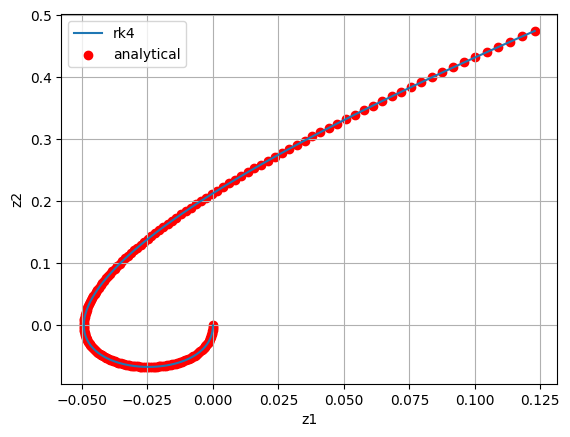

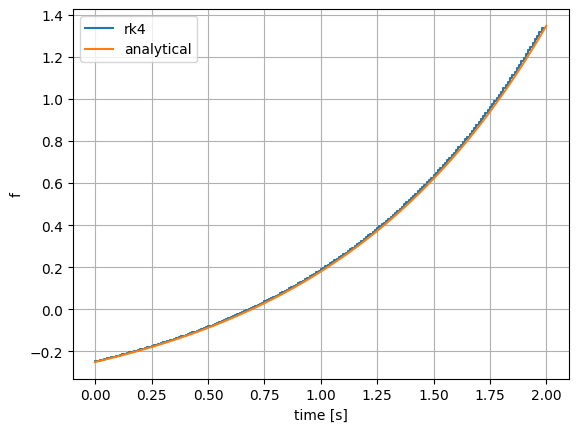

In [48]:
plt.plot(sol.value(X[0,:]),sol.value(X[1,:]),label=dop)
plt.scatter(z1s,z2s,label='analytical',c='r')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
plt.grid()
plt.show()
plt.figure()
plt.step(t,sol.value(cs.horzcat(U,cs.MX.nan())),label=dop)
plt.plot(t,us,label='analytical')
plt.xlabel('time [s]')
plt.ylabel('f')
plt.legend()
plt.grid()
plt.show()